# Lab 1 Part 3 - Twitter API Project

### UB CSE 487 Data Intensive Computing
Team member 1: Michael Brown (UBIT Name: mpbrown || UBIT number: 50158715)
<br /> Team member 2: Birender Singh (UBIT Name: birender || UBIT number: 50288934) 

### Shiny App for Comparison and Analysis

https://mpbrown.shinyapps.io/ub-cse487-Flu-Tweets-and-CDC/

## Library Dependencies

In [2]:
library(twitteR)
library(keyring)

library(lubridate)
library(glue)
library(dplyr)
library(tidyr)

library(ggmap)
library(ggplot2)
library(maptools)
library(maps)
library(usmap)

Warning message:
"package 'twitteR' was built under R version 3.5.2"Warning message:
"package 'keyring' was built under R version 3.5.2"Warning message:
"package 'lubridate' was built under R version 3.5.2"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'glue' was built under R version 3.5.2"Warning message:
"package 'dplyr' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following object is masked from 'package:glue':

    collapse

The following objects are masked from 'package:lubridate':

    intersect, setdiff, union

The following objects are masked from 'package:twitteR':

    id, location

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyr' was built under R version 3.5.2"Warning message:
"package 'ggmap' was built under R version 3.5.2"Loa

## Pre-Data Collection - API Registration

In [6]:
# Twitter API registration
setup_twitter_oauth(
  key_get("twitter_consumer_key", keyring = "mykeyring"),
  key_get("twitter_consumer_secret", keyring = "mykeyring"),
  key_get("twitter_access_token", keyring = "mykeyring"),
  key_get("twitter_access_secret", keyring = "mykeyring")
)

# Google API registration
register_google(key_get("GoogleAPI", keyring = "mykeyring"))

[1] "Using direct authentication"


## Selecting Tweet Keywords

We used the following keywords for the Twitter data collection. ***Note: in this lab, we are NOT interested in sentiment analysis. We are interested in sheer number of tweets*** on a topic that is associated with “flu” or a related term that you uniquely determine that will be important influencer.

In [14]:
# Set keywords
# flu vaccine h1n1 tamiflu influenza headache lymph sinus
keywords <- c("flu","vaccine","h1n1","tamiflu","influenza","headache","lymph","sinus")

## Selecting Tweet Date Range

In [ ]:
# Set date range
# (for tweets on a single day, make startDate and endDate identical)
startDate <- "2019-03-03"
endDate <- "2019-03-03"
dateRange <- seq(as.Date(startDate), as.Date(endDate), by=1)

## Collecting Tweets to CSV files
The loop below depends on us having previously set the **keywords** list as well as a **startDate** and an **endDate**. We decided to include the dates as option ***due to the limitations of the free standard Twitter API*** which only provides access to tweets from the last 7 days.

In [15]:
# Collect tweets for each keyword throughout date range
for(day in as.list(dateRange)){
  for(k in keywords){
    # Check current Twitter API rate limit
    myRateLimit <- getCurRateLimitInfo(c("search"))
    
    # If limit has been reached, sleep until API reset time
    if(myRateLimit$remaining < 1){
      resetTime <- myRateLimit$reset
      nowTime <- with_tz(Sys.time(), tz="UTC")
      sleepingTime <- as.numeric(resetTime-nowTime, units="secs")
      print(glue('Sleeping for ',{sleepingTime}))
      Sys.sleep(as.numeric(resetTime-nowTime, units="secs"))
    }
  
    searchWord <- as.character(k)
    
    # Construct filename based on keyword
    filename <- glue('tw-',{searchWord},'.csv')
    
    print(glue('Attemping search of ',{searchWord}, ' since ',as.character(day),' until ',as.character(day+1)))
    
    # Searches Twitter API for provided dates given searchWord, then strips any retweets, and converts to DF
    dtweets <- twListToDF(strip_retweets(searchTwitter(searchWord, n=900, since=as.character(day), until = as.character(day+1), retryOnRateLimit = 450)))
    
    print(glue('Completed search of ',{searchWord}, ' with ',{nrow(dtweets)},' rows'))
    
    print(glue('Appending to ',{filename}))
    if(!file.exists(filename)){
      write.csv(dtweets, file=filename)
    } else {
      existingCSV <- read.csv(file = filename, stringsAsFactors = F)
      existingCSV <- select(existingCSV, -c("X"))
      newCSV <- rbind(existingCSV, dtweets)
      write.csv(newCSV, file=filename)
    }
  }
}

## Pre-Geocoding - Selecting Keywords to Geocode

**IMPORTANT**
Choose either selected subset of keywords or all keywords (will take much longer due to API calls)

***Valid keywords:*** 

'flu' 'vaccine' 'h1n1' 'tamiflu' 'influenza' 'headache' 'lymph' 'sinus'

In [ ]:
geocodeTheseKeywords <- c('flu')

## Geocoding Tweets to U.S. states
Since very few tweets themselves are location-tagged, we make the **assumption that the *location of collected tweets* is the same as the *location of the tweet authors.***

In [17]:
for(k in geocodeTheseKeywords){
  geocoded.users <- NULL
  geocoded.users.nogeneric <- NULL
  filteredCSV <- NULL
  
  # Read in raw tweets from 'tw-{k}.csv'
  geoprep.data <- read.csv(glue('tw-',{k},'.csv'))
  
  # Drop all columns except for "id", "text", and "screenName" 
  geoprep.data <- select(geoprep.data, "id","text","screenName")
  
  # Rename "id" to "tweetID" to clarify
  geoprep.data <- rename(geoprep.data, tweetID = id)
  
  # Remove any duplicate tweets based on "tweetID"
  geoprep.data <- unique(geoprep.data, by = "tweetID")
  
  # --- Geocoding the tweet authors ---
  
  ## If keyword has already been geocoded, it skips this step and reads in 'geo-users-tw-{k}.csv' 
  if(!file.exists(glue('geo-users-tw-',{k},'.csv'))){
    # Query Twitter API for data frame of user profile information
    print("Attemping twitteR lookupUsers...")
    geoprep.users <- twListToDF(lookupUsers(as.character(geoprep.data$screenName), includeNA = FALSE))
    
    # Select only columns "screenName" and "location"
    geoprep.users <- select(geoprep.users, screenName, location)
    
    # Select only users with a non-empty location listed and only keep columns 'screenName' and 'location'
    geoprep.users <- subset(geoprep.users, location != "")
    
    # Query Google Maps API to geocode user locations
    geoprep.users.locgeocoded <- geocode(geoprep.users$location)
    
    # Add latitude and longitude columns to geocoded.users
    geocoded.users.latlng <- dplyr::mutate(geoprep.users, latitude = geoprep.users.locgeocoded$lat)
    geocoded.users.latlng <- dplyr::mutate(geocoded.users.latlng, longitude = geoprep.users.locgeocoded$lon)
    
    # Save geocoded information for this keyword to 'geo-users-tw-{k}.csv'
    write.csv(geocoded.users.latlng, file = glue('geo-users-tw-',{k},'.csv'))
  } else {
    ## If keyword had already been geocoded, it skips to this and reads in 'geo-users-tw-{k}.csv' 
    print(glue('Loading geo-users-',{k},'.csv'))
    geocoded.users <- read.csv(glue('geo-users-tw-',{k},'.csv'))
    
    # Drops the extra column that gets added at the beginning
    geocoded.users <- select(geocoded.users, -c("X"))
  }
  
  # --- File naming clarification ---
  # geo-users-nogeneric-{keyword}.csv means that imprecise rows as defined belowed have been dropped
  
  if(!file.exists(glue('geo-users-nogeneric-',{k},'.csv'))){
    
    # Drop imprecise rows where geocode failed such as locations of "sitting in grass" or "somewhere"
    geocoded.users.nogeneric <- drop_na(geocoded.users.latlng)
    
    # Drop imprecise rows where geocode returned merely the geographical center of the United States
    geocoded.users.nogeneric <- geocoded.users.nogeneric[!(geocoded.users.nogeneric$latitude==37.0902400 & geocoded.users.nogeneric$longitude==-95.7128910),]
    
    write.csv(geocoded.users.nogeneric, file = glue('geo-users-nogeneric-',{k},'.csv'))
    
  } else {
    
    ## If keyword data had already been cleared of imprecise rows, it skips to this and reads in 'geo-users-nogeneric-{k}.csv' 
    print(glue('Loading geo-users-nogeneric-',{k},'.csv'))
    geocoded.users.nogeneric <- read.csv(glue('geo-users-nogeneric-',{k},'.csv'))
    
    # Drops the extra column that gets added at the beginning
    geocoded.users.nogeneric <- select(geocoded.users.nogeneric, -c("X"))
    
  }
  
  # --- Reverse Geocoding ---
  
  if(!file.exists(glue('geo-filtered-',{k},'.csv'))){
    
    # Preparation
    geocoded.state.attached <- geocoded.users.nogeneric
    
    # Create data frame for the listing of states as a result of reverse geocoding
    statesToAttach <- data.frame(state=character(), stringsAsFactors=FALSE)
    
    # Makes sure i is initialized to 1
    i <- 1
    
    # Query Google reverse-geocode API and save list (of lists) result to testrevgeo
    for(i in seq(1, nrow(geocoded.users.nogeneric), 1)){
      
      # Query Google reverse-geocode API and save list (of lists) result to testrevgeo
      testrevgeo <- revgeocode(c(geocoded.users.nogeneric[i,4], geocoded.users.nogeneric[i,3]), output="all")
      # Handle cases where testrevgeo is NA, will be filtered out later
      if(is.na(testrevgeo)){
        statesToAttach <- add_row(statesToAttach, state = NA)
      } else {
        testrevgeo.results.length <- length(testrevgeo$results)
        # Handle any instances where the length is 1
        if(testrevgeo.results.length != 1){
          testrevgeo.results.length = testrevgeo.results.length - 1
        }
        
        mystate <- NA
        mystate <- tryCatch(
          {
            testrevgeo$results[[testrevgeo.results.length]]$address_components[[1]]$long_name
          }, error = function(e) {
            NA
          }
        )
        # Add parsed state name to row in statesToAttach data frame 
        statesToAttach <- add_row(statesToAttach, state = mystate)
      }
      
    }
    
    # Bind state names to geocoded.users.nogeneric
    newCSV <- cbind(geocoded.users.nogeneric, state = statesToAttach$state)
    
    # Filter out non-US states
    filteredCSV <- subset(newCSV, state %in% state.name)
    
    write.csv(filteredCSV, file=glue('geo-filtered-',{k},'.csv'))
  } else {
    print(glue('Loading geo-filtered-',{k},'.csv'))
    filteredCSV <- read.csv(glue('geo-filtered-',{k},'.csv'))
    filteredCSV <- select(filteredCSV, -c("X"))
  } 
  # Left outer join for filteredCSV and geoprep.data, join on screenName
  # Attaches user's location data to unique tweets made by that user
  uniqueGeoTweets <- merge(filteredCSV, geoprep.data, by = "screenName", all.x = TRUE)
  
  # Filters out any remaining duplicates
  uniqueGeoTweets <- unique(uniqueGeoTweets, by = "tweetID")
  write.csv(uniqueGeoTweets, file=glue('geo-unique-tweets-',{k},'.csv'))
}

# --- Final Collections for Keyword Tweets --- 

# geo-unique-tweets-{keyword}.csv now contains:
#   - screenName of user who wrote Tweet with keyword in it
#   - user profile's listed location
#   - latitude based on Google geocoding of user's location
#   - longitude based on Google geocoding of user's location
#   - U.S. state name based on Google reverse geocoding of user's coordinates
#   - unique Tweet ID from Twitter
#   - text of Tweet

## Plotting selected keyword Tweets per State
###### Loop through selected keywords

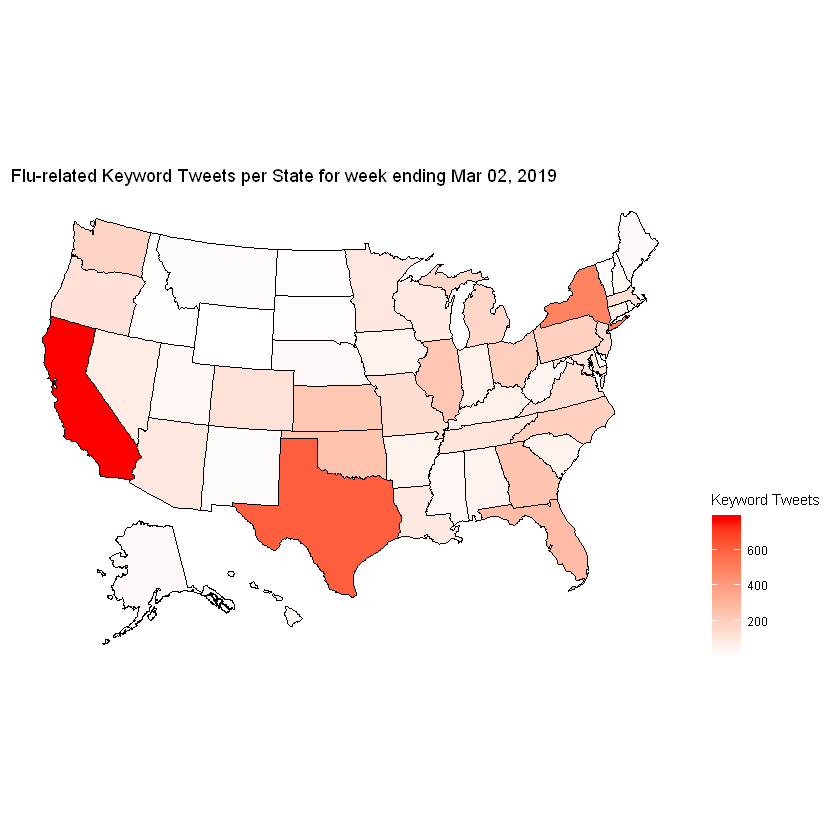

In [3]:
stateTweetFullList <- NULL
# Default option of plotting all keywords
plotTheseKeywords <- keywords

# Loop through selected keywords
for(k in plotTheseKeywords){
  if(is.null(stateTweetFullList)){
    # Used to establish data frame structure
    stateTweetFullList <- select(read.csv(glue('geo-unique-tweets-',{k},'.csv')), -c("X"))
  } else {
    # Append to existing data frame structure for stateTweetFullList
    uniqueCSV <- select(read.csv(glue('geo-unique-tweets-',{k},'.csv')), -c("X"))
    stateTweetFullList <- rbind(stateTweetFullList, uniqueCSV)
  }
}
# Filter out any remaining duplicates
stateTweetUniqueList <- unique(stateTweetFullList, by = "tweetID")

# Count the total number of keyword tweets per state
totalTweetsPerState <- count(stateTweetFullList, state)

# Plot the total number of selected keyword tweets per state
plot_usmap(regions = "states", data = totalTweetsPerState, values = "n", lines = "black")+
  labs(title ="Flu-related Keyword Tweets per State for week ending Mar 02, 2019")+
  scale_fill_continuous(low = "white", high = "red", name = "Keyword Tweets", label = scales::comma)+
  theme(legend.position = "right")